In [8]:
import os
import jax
import jax.numpy as jnp
import jax.random as random
import orbax.checkpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import ipywidgets as widgets
from IPython.display import display, clear_output
import jaxwt as jwt
from models.jax_vae_wavelet import VAE
from polymer.load_tfrecords import Dataloader

class VAEExplorer:
    def __init__(self, dataset_path, checkpoint_path, batch_size=16):
        self.dataset_path = dataset_path
        self.checkpoint_path = checkpoint_path
        self.batch_size = batch_size
        
        # Load model
        self.dataloader = Dataloader(
            tfrecord_pattern=os.path.join(dataset_path, "*.tfrecord"),
            batch_size=batch_size,
            enable_augmentation=False
        )
        self.jax_ds = self.dataloader.get_jax_iterator(shuffle=True)
        
        self.vae = VAE(base_features=32, latent_dim=128)
        
        # Fix for asyncio issue in Jupyter
        try:
            # Try the standard way first
            self.orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
            self.raw_restored = self.orbax_checkpointer.restore(checkpoint_path)
        except RuntimeError as e:
            if "asyncio.run() cannot be called from a running event loop" in str(e):
                # Use legacy checkpointer for Jupyter compatibility
                import asyncio
                import nest_asyncio
                nest_asyncio.apply()
                
                self.orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
                self.raw_restored = self.orbax_checkpointer.restore(checkpoint_path)
            else:
                raise e
        
        # Data
        self.images = None
        self.latents = None
        self.reconstructions = None
        self.tsne_2d = None
        
    def load_data(self, num_batches=50):
        """Load data and compute everything"""
        print(f"Loading {num_batches} batches...")
        
        all_images = []
        all_latents = []
        all_recons = []
        
        for i in range(num_batches):
            batch = next(self.jax_ds)
            imgs = batch['features']
            
            # Convert to wavelets
            waves = jwt.wavedec2(imgs, "haar", level=1, mode="reflect", axes=(1,2))
            waves_concat = jnp.concatenate([waves[0], waves[1][1], waves[1][0], waves[1][2]], axis=-1)
            
            # Get latents and reconstructions
            (x_recon, _, mu, _) = self.vae.apply(
                {'params': self.raw_restored['model']}, 
                waves_concat, 
                training=False, 
                key=random.key(0)
            )
            
            all_images.append(imgs)
            all_latents.append(mu)
            all_recons.append(x_recon)
            
            if (i + 1) % 10 == 0:
                print(f"  {i+1}/{num_batches} done")
        
        self.images = jnp.concatenate(all_images, axis=0)
        self.latents = jnp.concatenate(all_latents, axis=0)
        self.reconstructions = jnp.concatenate(all_recons, axis=0)
        
        print(f"✓ Loaded {len(self.images)} samples")
        
    def compute_and_plot_tsne(self, perplexity=30):
        """Compute t-SNE and create static plot with sample paths"""
        print("Computing 2D t-SNE...")
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
        self.tsne_2d = tsne.fit_transform(np.array(self.latents))
        print("✓ t-SNE done")
        
        # Create the plot
        plt.figure(figsize=(12, 10))
        
        # All points in grayscale
        colors = np.arange(len(self.tsne_2d)) // self.batch_size
        scatter = plt.scatter(
            self.tsne_2d[:, 0], self.tsne_2d[:, 1],
            c=colors, cmap='gray', s=30, alpha=0.6, edgecolors='black', linewidth=0.3
        )
        
        # Take 10 random samples and show their paths
        sample_indices = np.random.choice(len(self.images), 10, replace=False)
        
        for i, idx in enumerate(sample_indices):
            x, y = self.tsne_2d[idx]
            
            # Different marker for each sample
            markers = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', 'h', '+']
            plt.scatter([x], [y], c='red', s=150, marker=markers[i], 
                       edgecolors='black', linewidth=2, label=f'Sample {idx}')
            
            # Add text label
            plt.annotate(f'{idx}', (x, y), xytext=(5, 5), textcoords='offset points',
                       fontweight='bold', fontsize=8, color='red')
        
        plt.colorbar(scatter, label='Batch Index')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.title(f'VAE Latent Space (2D t-SNE) - {len(self.tsne_2d)} samples')
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        
        # Show the actual sample images in grayscale
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()
        
        for i, idx in enumerate(sample_indices):
            # Convert to grayscale for display
            img = self.images[idx]
            if len(img.shape) == 3:
                img_gray = np.mean(img, axis=-1)
            else:
                img_gray = img
                
            axes[i].imshow(img_gray, cmap='gray')
            axes[i].set_title(f'Sample {idx}')
            axes[i].axis('off')
        
        plt.suptitle('Sample Images from t-SNE Plot', fontsize=14)
        plt.tight_layout()
        plt.show()

    def create_image_browser(self):
        """Create image browser with reconstruction difference"""
        
        # Image selector
        image_slider = widgets.IntSlider(
            value=0,
            min=0,
            max=len(self.images)-1 if self.images is not None else 100,
            description='Image:',
            style={'description_width': '60px'}
        )
        
        # Diff threshold for highlighting
        diff_threshold = widgets.FloatSlider(
            value=0.3,
            min=0.0,
            max=1.0,
            step=0.05,
            description='Diff Threshold:',
            style={'description_width': '100px'}
        )
        
        # Output
        image_output = widgets.Output()
        
        def update_display(change=None):
            idx = image_slider.value
            
            with image_output:
                clear_output(wait=True)
                
                # Get images
                original = np.array(self.images[idx])
                reconstruction = np.array(self.reconstructions[idx])
                
                # Handle reconstruction shape (batch, height, width) -> (height, width)
                if len(reconstruction.shape) == 3:
                    reconstruction = reconstruction[0]  # Remove batch dimension
                
                # Convert to grayscale
                if len(original.shape) == 3:
                    orig_gray = np.mean(original, axis=-1)
                else:
                    orig_gray = original
                
                if len(reconstruction.shape) == 3:
                    recon_gray = np.mean(reconstruction, axis=-1)
                else:
                    recon_gray = reconstruction
                
                # Compute absolute difference
                abs_diff = np.abs(orig_gray - recon_gray)
                
                # Normalize difference to [0, 1]
                if abs_diff.max() > 0:
                    abs_diff_norm = abs_diff / abs_diff.max()
                else:
                    abs_diff_norm = abs_diff
                
                # Create difference overlay
                threshold = diff_threshold.value
                diff_mask = abs_diff_norm > threshold
                
                # Create plots
                fig, axes = plt.subplots(2, 2, figsize=(12, 10))
                
                # Original (grayscale)
                axes[0, 0].imshow(orig_gray, cmap='gray')
                axes[0, 0].set_title(f'Original Image {idx}')
                axes[0, 0].axis('off')
                
                # Reconstruction (grayscale)  
                axes[0, 1].imshow(recon_gray, cmap='gray')
                axes[0, 1].set_title(f'VAE Reconstruction {idx}')
                axes[0, 1].axis('off')
                
                # Difference heatmap
                axes[1, 0].imshow(abs_diff_norm, cmap='hot')
                axes[1, 0].set_title(f'Absolute Difference')
                axes[1, 0].axis('off')
                
                # Original with red overlay for high differences
                axes[1, 1].imshow(orig_gray, cmap='gray')
                
                # Create red overlay for differences above threshold
                red_overlay = np.zeros((*orig_gray.shape, 4))
                red_overlay[..., 0] = 1.0  # Red channel
                red_overlay[..., 3] = diff_mask * 0.6  # Alpha channel
                
                axes[1, 1].imshow(red_overlay)
                axes[1, 1].set_title(f'Original + Diff Overlay (>{threshold:.2f})')
                axes[1, 1].axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Stats
                mse = np.mean((orig_gray - recon_gray)**2)
                print(f"📊 Image {idx} stats:")
                print(f"   MSE: {mse:.6f}")
                print(f"   Mean abs diff: {abs_diff.mean():.6f}")
                print(f"   Max abs diff: {abs_diff.max():.6f}")
                print(f"   Pixels above threshold: {diff_mask.sum()} ({100*diff_mask.sum()/diff_mask.size:.1f}%)")
                
                # t-SNE location
                if self.tsne_2d is not None:
                    tsne_point = self.tsne_2d[idx]
                    print(f"   t-SNE coordinates: ({tsne_point[0]:.2f}, {tsne_point[1]:.2f})")
        
        # Connect callback
        image_slider.observe(update_display, 'value')
        diff_threshold.observe(update_display, 'value')
        
        # Create UI
        controls = widgets.VBox([
            widgets.HTML("<h2>🖼️ Image Browser with Reconstruction Analysis</h2>"),
            image_slider,
            diff_threshold,
            widgets.HTML("<p>Red overlay shows pixels with reconstruction error above threshold</p>")
        ])
        
        ui = widgets.VBox([controls, image_output])
        
        # Initialize display
        update_display()
        
        return ui

Found 8 TFRecord files
Total samples: 128
Batches per epoch: 8
Computing global statistics...
Computed stats: mean=32098.3, std=22469.1


/usr/local/lib/python3.11/dist-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1269: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


Loading 50 batches...
  10/50 done
  20/50 done
  30/50 done
  40/50 done
  50/50 done
✓ Loaded 800 samples
Computing 2D t-SNE...
✓ t-SNE done


/tmp/ipykernel_12253/2572265457.py:116: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter([x], [y], c='red', s=150, marker=markers[i],


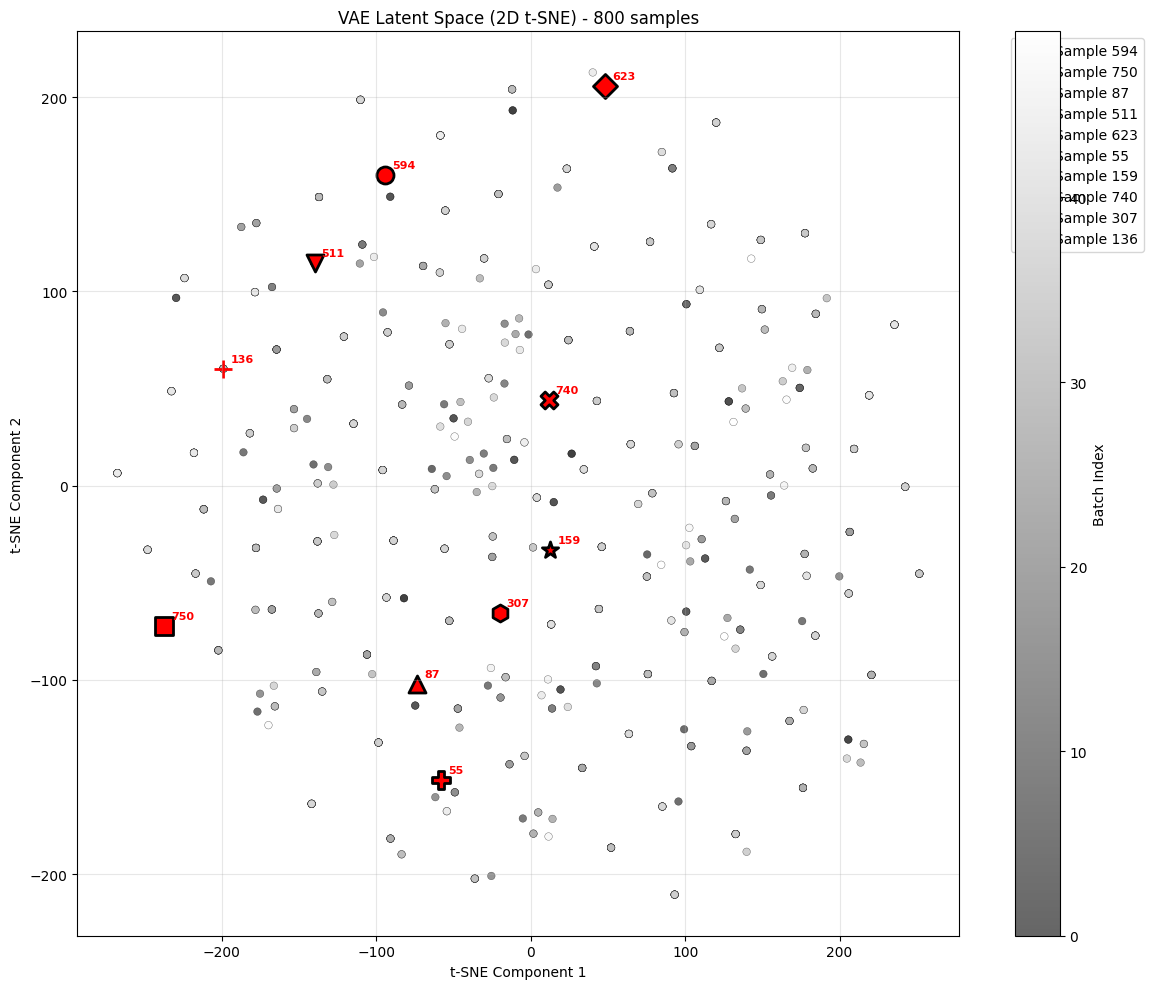

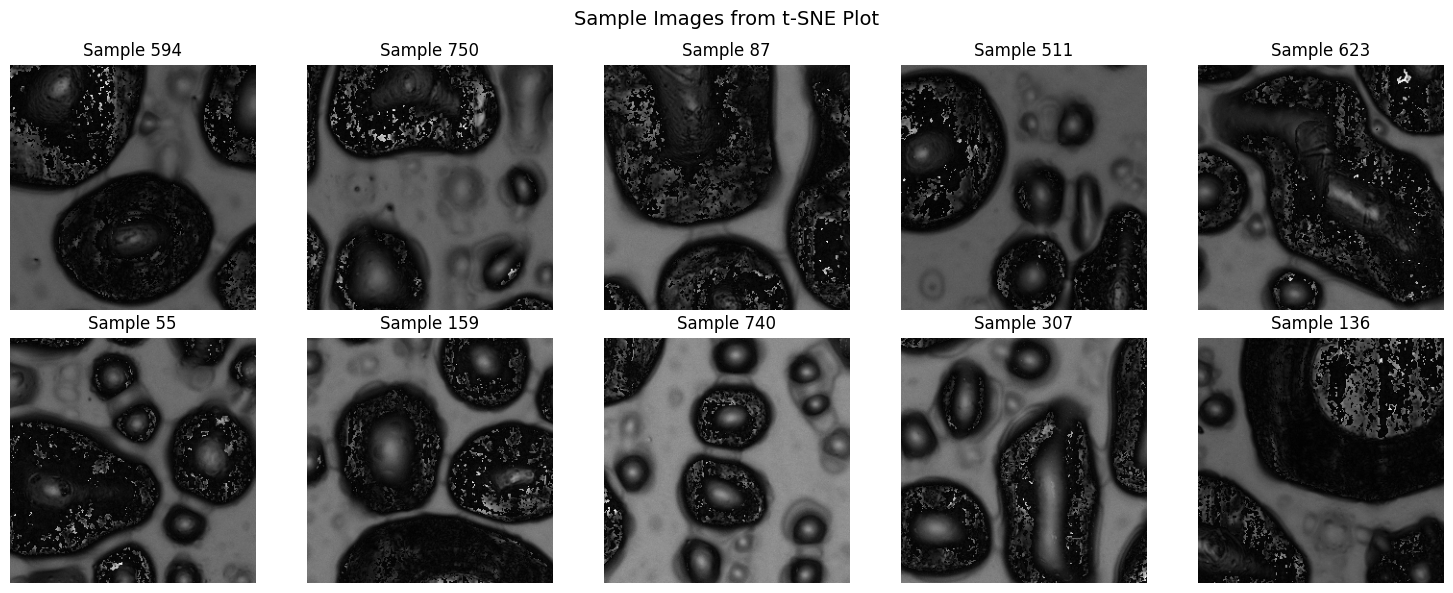

In [10]:
# Initialize
viz = VAEExplorer(
    dataset_path='/data/tfrecords_pe',
    checkpoint_path='/data/experiments/vae_baseline_20250905_123021' + '/model_checkpoint'
)
viz.load_data(50)
viz.compute_and_plot_tsne(perplexity=30)
browser = viz.create_image_browser()
display(browser)